# **METODE TRADISIONAL**

## **Memuat Pustaka dan *Dataset***

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/cars-detection")

print("Path to dataset files:", path)

100%|██████████| 38.2M/38.2M [00:00<00:00, 66.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdallahwagih/cars-detection/versions/1


In [3]:
DATASET_PATH = f"{path}/Cars Detection"  # Ganti dengan path ke folder dataset Anda

# Fungsi untuk membaca file gambar dan label

def load_images_and_labels(dataset_path):
    images = []
    labels = []
    for split in ['train', 'valid', 'test']:
        img_folder = os.path.join(dataset_path, split, 'images')
        label_folder = os.path.join(dataset_path, split, 'labels')

        for img_file in os.listdir(img_folder):
            img_path = os.path.join(img_folder, img_file)
            label_path = os.path.join(label_folder, img_file.replace('.jpg', '.txt'))

            if os.path.exists(img_path) and os.path.exists(label_path):
                images.append(img_path)
                labels.append(label_path)
    return images, labels

annotations, label_paths = load_images_and_labels(DATASET_PATH)
print(len(annotations), len(label_paths))

1254 1254


## **SEGMENTASI**

In [6]:
def segment_image(image_path):
    img = cv2.imread(image_path)
    b, g, r = cv2.split(img)
    rgb_img = cv2.merge([r, g, b])  # Convert BGR to RGB for display

    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(closing, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    markers[unknown == 255] = 0

    # Watershed algorithm
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Mark the boundaries

    # Extract the segmented image using the threshold mask
    segmented_image = img.copy()  # Start with a copy of the original image
    segmented_image[thresh == 0] = [0, 0, 0]  # Set the background to black

    return (thresh, segmented_image)

In [65]:
import tqdm

segmented_image = []
thresh_image = []

for img_path in tqdm.tqdm(annotations, desc="Segmenting Images"):
    hold = segment_image(img_path)
    segmented_image.append(hold[1])
    thresh_image.append(hold[0])

Segmenting Images: 100%|██████████| 1254/1254 [00:21<00:00, 58.23it/s]


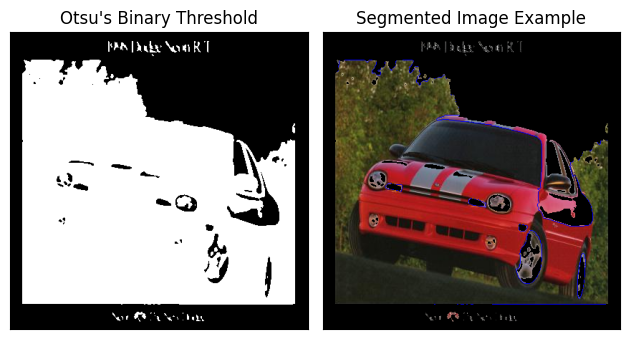

In [66]:
plt.subplot(121), plt.imshow(thresh_image[0], 'gray')
plt.title("Otsu's Binary Threshold"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(cv2.cvtColor(segmented_image[0], cv2.COLOR_BGR2RGB))
plt.title("Segmented Image Example"), plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()

## **EKSTRAKSI FITUR**

In [67]:
features = []
labels = []
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

for image, label_path in zip(segmented_image, label_paths):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # Resize gambar ke ukuran tetap

    # Ekstraksi fitur HOG
    hog_features = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       visualize=False)
    features.append(hog_features)

    # Gunakan label pertama dari file label sebagai representasi gambar
    with open(label_path, 'r') as f:
        first_line = f.readline().strip()
        cls = int(first_line.split()[0])  # Ambil class ID dari label pertama
        labels.append(cls)

# Konversi ke numpy array
features = np.array(features)
labels = np.array(labels)

In [69]:
print(features[1])

[0.08847621 0.12097617 0.06363307 ... 0.16992609 0.00512404 0.00485177]


In [57]:
def extract_features(segmented_image):
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # Resize gambar ke ukuran tetap

    # Ekstraksi fitur HOG
    hog_features = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       visualize=False)
    return (hog_features)

## **PEMBANGUNAN MODEL KLASIFIKASI**

### Latih Model SVM

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [36]:
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

### Simpan Model

In [39]:
from google.colab import drive
import joblib

drive.mount('/content/drive')
model_path = "/content/drive/My Drive/svm_vehicle_detection_model.pkl"

joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

Mounted at /content/drive
Model saved to /content/drive/My Drive/svm_vehicle_detection_model.pkl


### Pengujian Model

In [37]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 84.86%


In [38]:
print("Jawaban model:", y_pred)
print("Jawaban benar:", y_test)

Jawaban model: [2 3 2 3 2 2 2 2 3 2 2 2 2 2 0 4 2 2 3 0 3 0 2 2 0 0 2 4 0 2 2 0 2 1 0 4 0
 2 1 1 2 0 2 2 3 2 2 3 2 2 4 3 2 0 1 0 1 2 1 2 0 2 4 1 0 3 2 4 3 2 2 0 3 2
 1 1 2 3 4 2 2 1 2 2 2 4 2 2 1 3 2 2 2 2 1 0 4 0 0 1 4 2 4 0 4 2 2 4 4 0 3
 2 2 0 4 4 3 2 3 2 2 1 3 4 2 2 2 2 2 1 0 4 0 2 1 2 2 2 0 2 2 4 2 2 4 2 2 2
 2 3 0 0 2 2 0 0 4 3 2 2 2 3 2 2 4 2 2 2 3 3 2 2 0 2 2 2 1 0 0 2 2 4 0 4 2
 1 3 0 1 0 0 2 1 1 1 2 2 0 0 3 4 2 2 1 2 4 4 0 2 2 0 4 2 3 4 3 1 2 3 1 1 2
 3 2 2 1 1 2 0 2 2 2 2 1 1 2 3 3 2 2 2 4 2 2 2 2 2 1 1 2 2]
Jawaban benar: [2 3 2 3 2 2 4 2 3 2 4 2 2 1 0 4 2 4 1 0 3 0 2 2 0 0 2 4 4 2 4 0 2 1 0 4 4
 2 1 1 2 0 2 2 3 2 2 3 2 2 4 3 2 0 1 0 1 3 1 3 0 2 4 1 4 3 2 4 3 2 2 0 3 2
 1 1 2 3 4 2 2 1 2 2 2 4 2 4 1 3 2 2 2 2 1 0 4 0 0 1 4 4 4 0 4 3 2 4 4 0 3
 2 0 0 4 4 3 2 4 2 2 4 3 4 2 2 2 2 2 1 0 4 0 2 1 2 2 2 0 2 2 4 2 1 4 1 2 3
 2 0 0 0 2 2 0 0 4 3 2 2 2 3 2 2 4 2 2 4 1 3 2 2 0 3 2 2 1 0 0 2 2 4 4 4 2
 1 3 4 1 0 0 4 1 4 1 2 2 0 4 0 4 2 3 1 2 4 4 0 2 2 1 4 3 3 4 3 1 2 4 1 1 3
 3 2 2 1 1

## **MENGGAMBAR *BOUNDING BOX***
### berdasarkan hasil segmentasi dan prediksi

In [97]:
def visualize_bboxes(thresh_image, original_image, classname):
    y_non_zero, x_non_zero = np.nonzero(thresh_image)

    if len(x_non_zero) > 0 and len(y_non_zero) > 0:
        x_min, x_max = x_non_zero.min(), x_non_zero.max()
        y_min, y_max = y_non_zero.min(), y_non_zero.max()

    # Gambar bounding box pada gambar asli
    cv2.rectangle(original_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

    # Tentukan posisi teks
    text_x = x_min
    text_y = y_min - 10

    if text_y < 10:
        text_y = y_max - 10
        text_x = text_x + 20

    # Tambahkan label
    cv2.putText(original_image, classname, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    plt.figure()
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

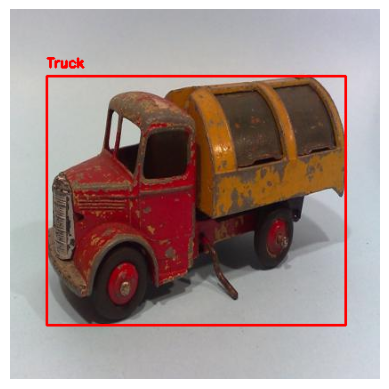

In [90]:
original_image = cv2.imread(annotations[900])
visualize_bboxes(thresh_image[900], original_image, "Truck")

## **FUNGSI GABUNGAN**

In [99]:
def predict(image_path):
    thresh_image, segmented_image = segment_image(image_path)
    features = extract_features(segmented_image)
    prediction = model.predict([features])[0]
    classname = class_names[prediction]

    original_image = cv2.imread(image_path)
    visualize_bboxes(thresh_image, original_image, classname)

## **PENGUJIAN YANG SESUNGGUHNYA**

Model loaded successfully!


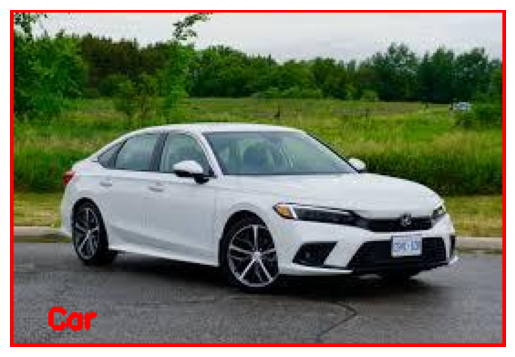

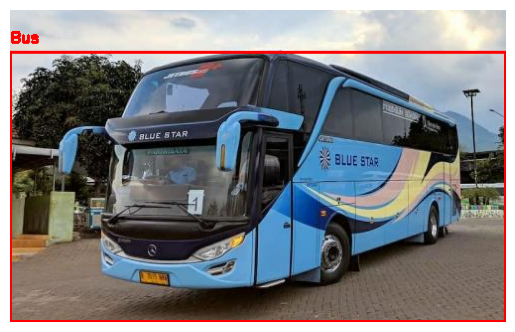

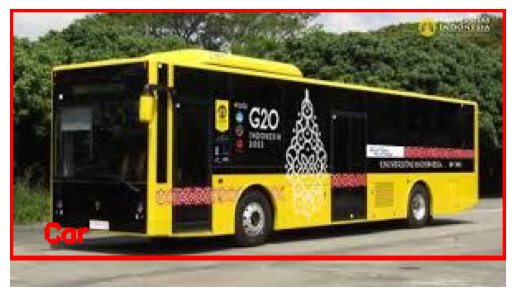

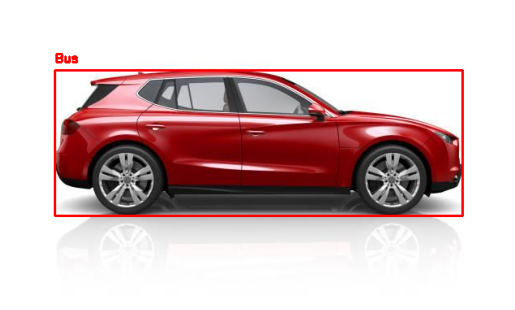

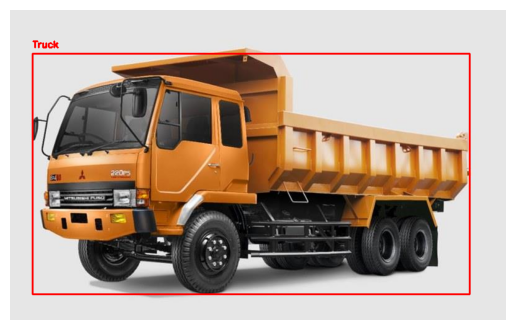

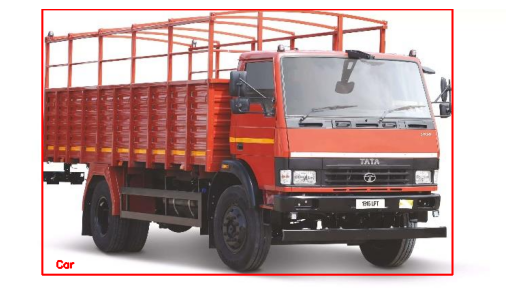

In [100]:
# Memuat model terlatih
model = joblib.load(model_path)
print("Model loaded successfully!")

# Path ke gambar
img_paths = ["1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg", "6.jpg"]

# Deteksi kendaraan
for img_path in img_paths:
    predict(img_path)

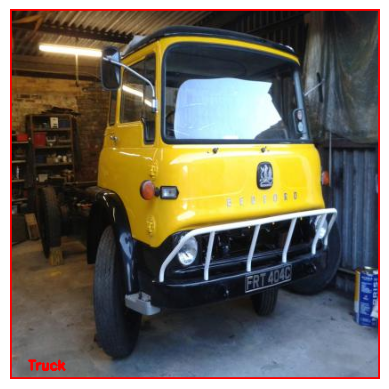

In [112]:
predict(annotations[765])